# Dependencies

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/UCL/3x2_analytical/scripts`


In [2]:
using LinearAlgebra
using Turing
using LimberJack
using MicroCanonicalHMC
using CSV
using DataFrames
using YAML
using NPZ
using JLD2
using PythonCall
using Statistics
using StatsPlots
sacc = pyimport("sacc");

[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
Precompiling TuringOptimExt
  ✓ Turing → TuringOptimExt
  1 dependency successfully precompiled in 54 seconds. 272 already precompiled.
[ Info: Precompiling TuringOptimExt [cd2420fc-8d31-5c39-8d98-0365cfcf7d6e]
┌ Warning: Module Turing with build ID fafbfcfd-c149-576f-0000-017a0595955e is missing from the cache.
│ This may mean Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing TuringOptimExt [cd2420fc-8d31-5c39-8d98-0365cfcf7d6e].
Precompiling LimberJack
  ✓ LimberJack
  1 dependency successfully precompiled in 2 seconds. 53 already precompiled.
[ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
Precompiling SciMLBasePythonCallExt
  ✓ SciMLBase → SciMLBasePythonCallExt
  1 dependency successfully precompiled in 8 seconds. 127 already precom

# Data

In [3]:
method = "bpz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc.yml"
nz_path = string("../data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("../data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean = dz_mean[11:20]
dz_cov = dz_cov[11:20, 11:20]
dz_chol = cholesky(dz_cov).U'

meta, files = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]

cov = meta.cov
Γ = sqrt(cov)
iΓ = inv(Γ);

init_params = [0.2734714358876248, 0.42170616570847225, 0.7189925511925751, 0.7790071910238021, 0.9965136823002241]

lens_0 lens_0 8
lens_1 lens_0 8
lens_1 lens_1 9
lens_2 lens_0 8
lens_2 lens_1 9
lens_2 lens_2 10
lens_3 lens_0 8
lens_3 lens_1 9
lens_3 lens_2 10
lens_3 lens_3 11
lens_4 lens_0 8
lens_4 lens_1 9
lens_4 lens_2 10
lens_4 lens_3 11
lens_4 lens_4 11
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{Float64}:
 0.2734714358876248
 0.42170616570847225
 0.7189925511925751
 0.7790071910238021
 0.9965136823002241

# Model

In [4]:
function make_theory(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta, files=files)
     nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909)
        
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
            tk_mode=:EisHu,
            pk_mode=:Halofit)

    return Theory(cosmology, meta, files; Nuisances=nuisances)
end

make_theory (generic function with 1 method)

In [5]:
fake_data = make_theory();
fake_data = iΓ * fake_data
data = fake_data

139-element Vector{Float64}:
  0.8665730103575667
  1.80379398156211
  2.9980758404831884
  5.14940568396759
 10.140646913530178
 18.84614591199148
 34.72637080854234
 56.92193845764497
  0.20474798058864221
  0.35264942062267685
  0.4066054898956868
  0.3821565415625734
  0.04750399368172381
  ⋮
  2.2420285926276113
  0.8032341393476702
  1.4855537626020234
  2.147921545835163
  3.113600736780586
  4.758815429506602
  6.7765337121055715
  9.663919516582965
 13.974499087286295
 19.950210681506764
 28.34733882496198
 39.92004235958697

In [6]:
@model function model(data)
    Ωm ~ Normal(0.3, 0.05)
    Ωbb ~ Normal(0.4, 0.05) # 10*Ωb 
    Ωb := 0.1*Ωbb 
    h ~ Normal(0.72, 0.05)
    σ8 ~ Normal(0.7, 0.2)
    ns ~ Normal(0.95, 0.05)

    theory := make_theory(Ωm=Ωm, Ωb=Ωb, h=h, σ8=σ8, ns=ns)
    ttheory = iΓ * theory
    d = fake_data - ttheory
    Xi2 := dot(d, d)
    data ~ MvNormal(ttheory, I)
end


model (generic function with 2 methods)

# Settings

In [7]:
iterations = 2000
adaptation = 500
TAP = 0.65

println("sampling settings: ")
println("iterations ", iterations)
println("TAP ", TAP)
println("adaptation ", adaptation)
#println("nchains ", nchains)

# Start sampling.
folpath = "../chains_test/"
folname = string("CosmoDC2_gcgc_nomarg_TAP_", TAP)
folname = joinpath(folpath, folname)

if isdir(folname)
    fol_files = readdir(folname)
    println("Found existing file ", folname)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[7])
        #println("Restarting chain")
    else
        #println("Starting new chain")
        last_n = 0
    end
else
    mkdir(folname)
    println(string("Created new folder ", folname))
    last_n = 0
end

# Create a placeholder chain file.
CSV.write(joinpath(folname, string("chain_", last_n+1,".csv")), Dict("params"=>[]), append=true)

sampling settings: 
iterations 2000
TAP 0.65
adaptation 500
Found existing file ../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65


"../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65/chain_1.csv"

# Sample

In [14]:
cond_model = model(data)
mchmc = MCHMC(0, 0.001;
    L=10.0,
    eps=0.000001,
    tune_eps=false,
    tune_L=false, 
    tune_sigma=false,
    adaptive=true)
espl = externalsampler(mchmc)
chain = sample(cond_model, espl, 20_000;
                init_params=init_params,
                progress=true, save_state=true);


Sampling: 100%|█████████████████████████████████████████| Time: 0:28:33


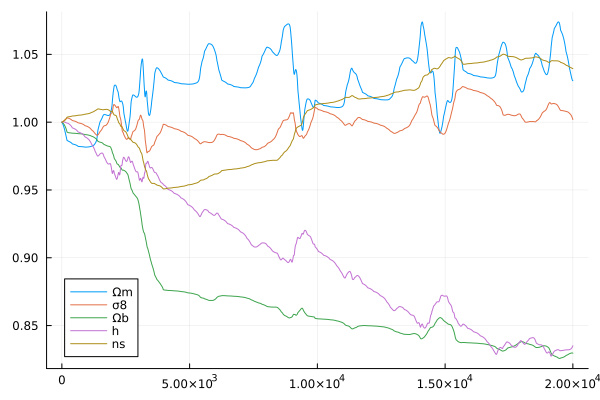

In [15]:
plot(chain["Ωm"]/0.27347, label="Ωm")
plot!(chain["σ8"]/0.779007 , label="σ8")
plot!(chain["Ωb"]/0.04217, label="Ωb")
plot!(chain["h"]/0.71899, label="h")
plot!(chain["ns"]/0.99651, label="ns")

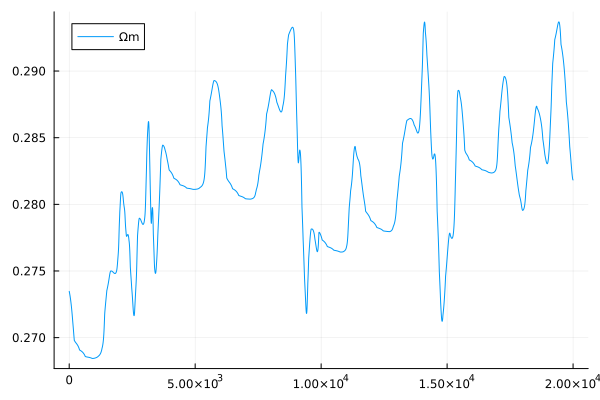

In [16]:
plot(chain["Ωm"], label="Ωm")

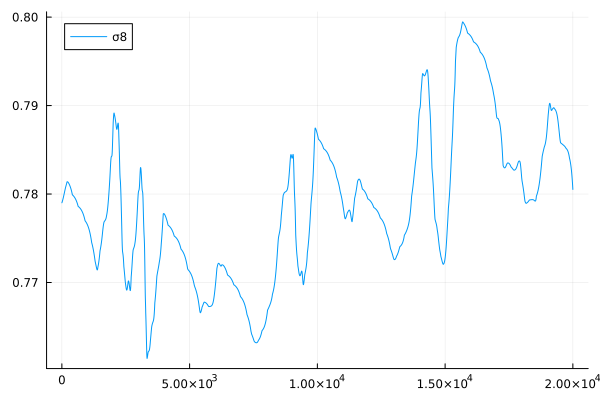

In [17]:
plot(chain["σ8"], label="σ8")

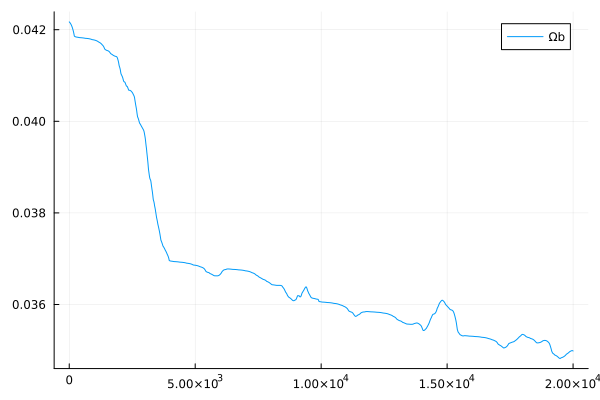

In [18]:
plot(chain["Ωb"], label="Ωb")

In [13]:
# Save the actual chain.       
@save joinpath(folname, string("chain_", last_n+1,".jls")) chain
CSV.write(joinpath(folname, string("chain_", last_n+1,".csv")), chain)
CSV.write(joinpath(folname, string("summary_", last_n+1,".csv")), describe(chain)[1])

┌ Warning: Attempting to store typeof(model).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(identity).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store ComposedFunction{Accessors.IndexLens{Tuple{Int64}}, typeof(identity)}.
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(MicroCanonicalHMC.Leapfrog).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(MicroC

"../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65/summary_1.csv"